In [1]:
import numpy as np # We'll be storing our data as numpy arrays
import os # For handling directories
from PIL import Image # For handling the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Plotting

lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('Train_Final/leapGestRecog/00/'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'01_palm': 0,
 '02_l': 1,
 '03_fist': 2,
 '04_fist_moved': 3,
 '05_thumb': 4,
 '06_index': 5,
 '07_ok': 6,
 '08_palm_moved': 7,
 '09_c': 8,
 '10_down': 9}

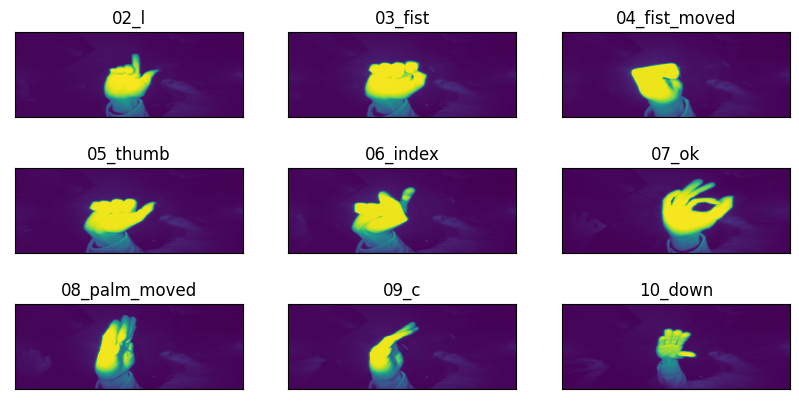

In [2]:
x_data = []
y_data = []
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir('Train_Final/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('Train_Final/leapGestRecog/0' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                img = Image.open('Train_Final/leapGestRecog/0' + 
                                 str(i) + '/' + j + '/' + k).convert('L')
                                # Read in and convert to greyscale
                img = img.resize((320, 120))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

plt.figure(1, figsize=(10,5))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(x_data[i*200 , :, :])
    plt.xticks([])
    plt.yticks([])
    plt.title(reverselookup[y_data[i*200 ,0]])

In [3]:
import keras
from keras.utils import to_categorical
y_data = to_categorical(y_data)

x_data = x_data.reshape((datacount, 120, 320, 1))
x_data /= 255

In [4]:
from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(x_data,y_data, test_size = 0.20, random_state=0)
# X_train.shape,y_train.shape,X_test.shape,y_test.shape

x_train,x_further,y_train,y_further = train_test_split(x_data,y_data,test_size = 0.20)
x_validate,x_test,y_validate,y_test = train_test_split(x_further,y_further,test_size = 0.5)
x_train.shape, x_validate.shape, y_train.shape, y_validate.shape, x_test.shape, y_test.shape

((16000, 120, 320, 1),
 (2000, 120, 320, 1),
 (16000, 10),
 (2000, 10),
 (2000, 120, 320, 1),
 (2000, 10))

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate
from tensorflow.keras.applications import VGG16
from keras.models import Sequential,load_model

# Load the pre-trained VGG16 model without the top classification layer
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(120, 320, 3))

# Freeze the pre-trained layers in VGG16
for layer in vgg16.layers:
    layer.trainable = False

# Convert single-channel input to three channels
model = Sequential()
model.add(tf.keras.layers.Lambda(lambda x: tf.concat([x, x, x], axis=-1), input_shape=(120, 320, 1)))

# Add the VGG16 base model
model.add(vgg16)

# Add custom classification layers on top of VGG16
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
#model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
#model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
         optimizer = 'rmsprop',
         metrics = ['accuracy'])

history = model.fit(x_train, y_train, epochs = 3, batch_size=64, validation_data=(x_validate, y_validate))

print("Train accuracy:", history.history['accuracy'][-1])
print("Val accuracy:", history.history['val_accuracy'][-1])

print("Train loss:", history.history['loss'][-1])
print("Val loss:", history.history['val_loss'][-1])

test_loss, test_accuracy = model.evaluate(x_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_accuracy*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 120, 320, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 3, 10, 512)        14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                        

In [6]:
# Predict labels for test data
y_pred = model.predict(x_test)

# Convert predicted labels to one-hot encoded format
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import precision_recall_fscore_support

# Assuming you have y_pred_classes and y_test_classes

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_classes, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

63/63 [==============================] - 4s 69ms/step
Precision: 0.9920795019130589
Recall: 0.992
F1 Score: 0.9919992655959146


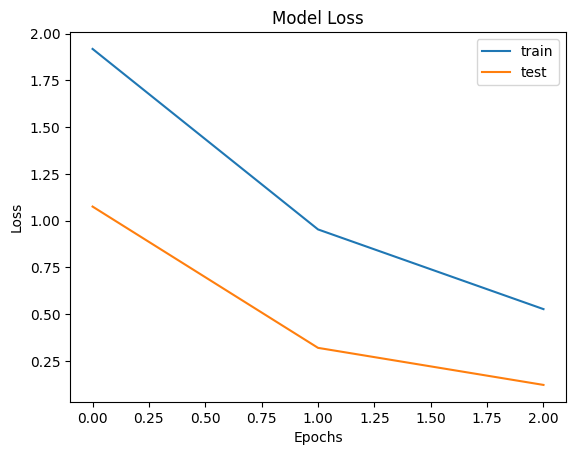

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

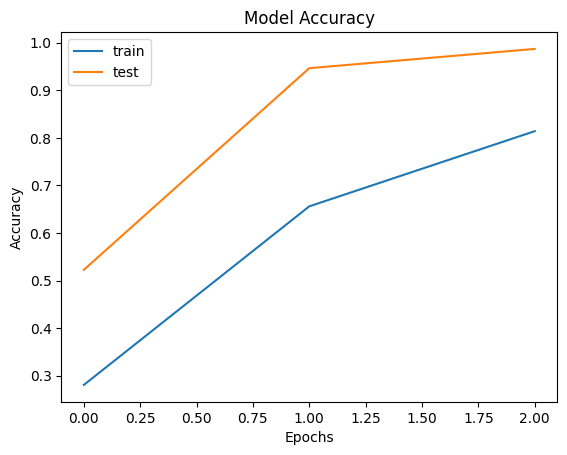

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

63/63 [==============================] - 4s 70ms/step


[]

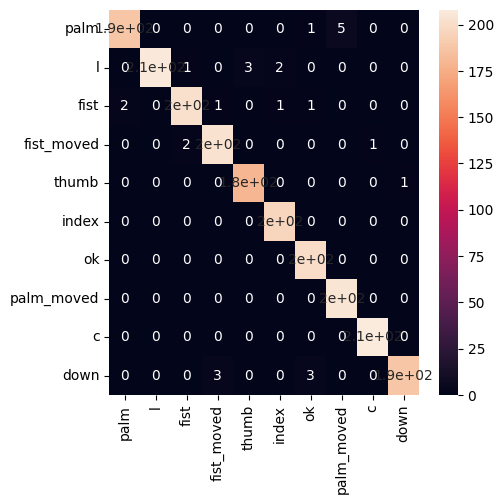

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cat = [c[3:] for c in lookup]
plt.figure(figsize=(5,5))
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(x_test), axis=1))
sn.heatmap(cm, annot=True,xticklabels=cat, yticklabels=cat)
plt.plot()

AIX (SHAP)

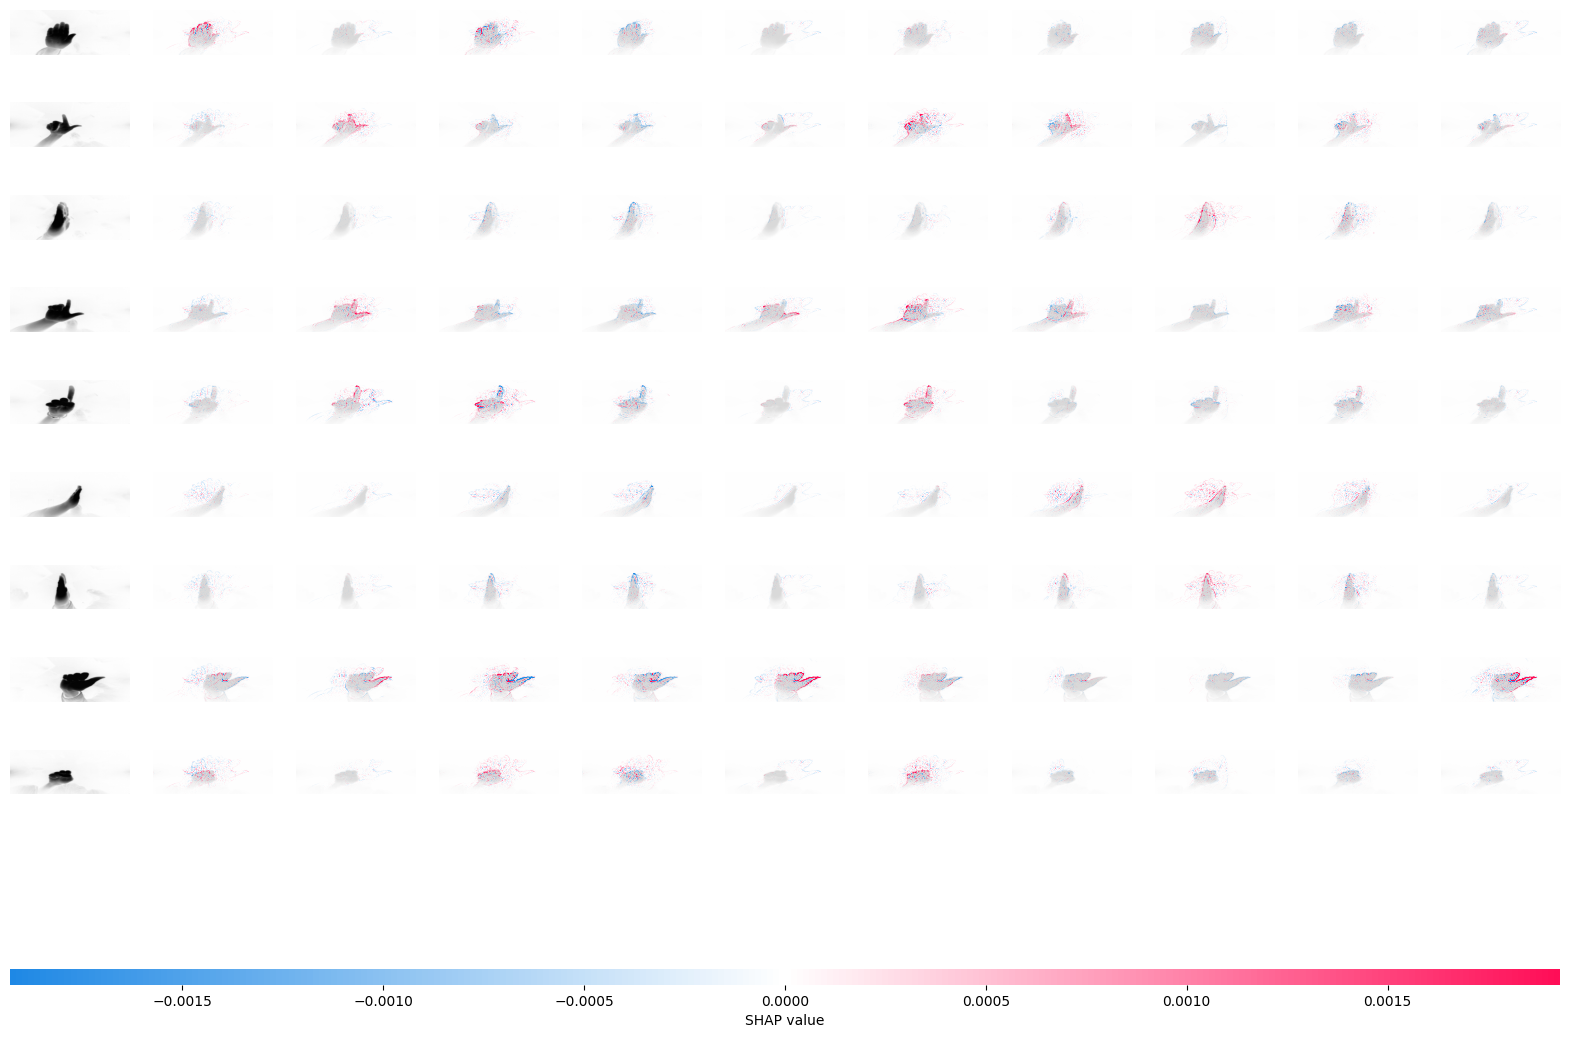

In [11]:
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 10, replace=False)]

# explain predictions of the model on ten images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:10])

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:10])

AIX (Lime)

In [11]:
# import lime
# import lime.lime_image
# import numpy as np
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
# from skimage.segmentation import slic

# # Load the pre-trained VGG16 model without the top classification layer
# vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(120, 320, 3))

# # Freeze the pre-trained layers in VGG16
# for layer in vgg16.layers:
#     layer.trainable = False

# # Create the complete model with VGG16 base
# model = Sequential()
# model.add(tf.keras.layers.Lambda(lambda x: tf.concat([x, x, x], axis=-1), input_shape=(120, 320, 1)))
# model.add(vgg16)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(64, activation='relu'))
# # model.add(Dropout(0.5))
# # model.add(Dense(64, activation='relu'))
# # model.add(Dropout(0.5))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(10, activation='sigmoid'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy'])

# history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_validate, y_validate))

# # Create an explainer object
# explainer = lime.lime_image.LimeImageExplainer()

# # Define the prediction function
# def predict_fn(images):
#     return model.predict(images)

# # Keep track of seen classes and corresponding Lime explanations
# seen_classes = set()
# lime_explanations = []

# # Iterate over the test set and explain a single sample from each class using LIME
# for i in range(len(x_test)):
#     sample_images = x_test[i][0]
#     sample_labels = x_test[i][1]
    
#     for j in range(len(sample_images)):
#         sample_image = sample_images[j]
#         sample_label = np.argmax(sample_labels[j])
        
#         # Check if the current sample belongs to a new class
#         if sample_label not in seen_classes:
#             # Reshape the sample_image to match the expected input shape of the model
#             sample_image = np.expand_dims(sample_image, axis=0)
            
#             # Apply superpixel segmentation using SLIC algorithm
#             segments = slic(sample_image[0], n_segments=100, compactness=10, sigma=1)
            
#             # Explain the image using LIME
#             explanation = explainer.explain_instance(sample_image[0], predict_fn, top_labels=1, num_samples=1000)
            
#             # Add the explanation to the lime_explanations list
#             lime_explanations.append((sample_image[0], explanation))
            
#             # Add the class to the seen_classes set
#             seen_classes.add(sample_label)
            
#             if len(seen_classes) == 10:
#                 break  # Exit the loop if all 10 classes are seen

#     if len(seen_classes) == 10:
#         break  # Exit the outer loop if all 10 classes are seen

# # Display the Lime explanations
# fig, axes = plt.subplots(10, 2, figsize=(8, 30))

# for i, (image, explanation) in enumerate(lime_explanations):
#     ax1 = axes[i, 0]
#     ax2 = axes[i, 1]
    
#     # Show the original image
#     ax1.imshow(image)
#     ax1.axis('off')
#     ax1.set_title('Label: {}'.format(list(seen_classes)[i]))
    
#     # Show the Lime explanation
#     lime_image, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
#     ax2.imshow(lime_image)
#     ax2.imshow(mask, cmap='jet', alpha=0.7)
#     ax2.axis('off')
#     ax2.set_title('LIME Explanation')

# plt.tight_layout()
# plt.show()


In [16]:
import lime
import lime.lime_image
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from skimage.segmentation import slic
import matplotlib.pyplot as plt

# Load the pre-trained VGG16 model without the top classification layer
# vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(120, 320, 1))
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Freeze the pre-trained layers in VGG16
for layer in vgg16.layers:
    layer.trainable = False

# Create the complete model with VGG16 base
model = Sequential()
model.add(vgg16)
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(10, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_data=(x_test, y_test))

# Create an explainer object
explainer = lime.lime_image.LimeImageExplainer()

# Define the prediction function
def predict_fn(images):
    preprocessed_images = preprocess_input(images)
    return model.predict(preprocessed_images)

# Keep track of seen classes and corresponding Lime explanations
seen_classes = set()
lime_explanations = []

# Iterate over the test set and explain a single sample from each class using LIME
for i in range(len(x_test)):
    sample_image = x_test[i][0]
    sample_label = np.argmax(x_test[i][1])
    
    # Check if the current sample belongs to a new class
    if sample_label not in seen_classes:
        # Convert the single-channel grayscale image to three-channel RGB image
        sample_image_rgb = np.repeat(sample_image, 3, axis=-1)
        
        # Reshape the sample_image to match the expected input shape of the model
        sample_image_rgb = np.expand_dims(sample_image_rgb, axis=0)
        
        # Apply superpixel segmentation using SLIC algorithm
        segments = slic(sample_image_rgb[0], n_segments=100, compactness=10, sigma=1)
        
        # Explain the image using LIME
        explanation = explainer.explain_instance(sample_image_rgb[0], predict_fn, top_labels=1, num_samples=1000)
        
        # Add the explanation to the lime_explanations list
        lime_explanations.append((sample_image_rgb[0], explanation))
        
        # Add the class to the seen_classes set
        seen_classes.add(sample_label)
        
        if len(seen_classes) == 10:
            break  # Exit the loop if all 10 classes are seen

# Display the Lime explanations
fig, axes = plt.subplots(10, 2, figsize=(8, 30))

for i, (image, explanation) in enumerate(lime_explanations):
    ax1 = axes[i, 0]
    ax2 = axes[i, 1]
    
    # Show the original image
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Label: {}'.format(list(seen_classes)[i]))
    
    # Show the Lime explanation
    lime_image, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
    ax2.imshow(lime_image)
    ax2.imshow(mask, cmap='jet', alpha=0.7)
    ax2.axis('off')
    ax2.set_title('LIME Explanation')

plt.tight_layout()
plt.show()


Epoch 1/5


ValueError: in user code:

    File "c:\Users\SHAKIB\anaconda3\envs\new_gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\SHAKIB\anaconda3\envs\new_gpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\SHAKIB\anaconda3\envs\new_gpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\SHAKIB\anaconda3\envs\new_gpu\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\SHAKIB\anaconda3\envs\new_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\SHAKIB\anaconda3\envs\new_gpu\lib\site-packages\keras\engine\input_spec.py", line 296, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 200, 200, 3), found shape=(10, 120, 320, 1)
